# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [ ]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [ ]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [ ]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(46, 6)


,title,price,year,link,brand,age
0,a sweet sedan avalon xle plus,24000,NaN,https://charlottesville.craigslist.org/cto/d/c...,missing,NaN
1,"1998 gmc sierra 1500 sl truck auto rwd <103,00...",6950,1998.0,https://charlottesville.craigslist.org/cto/d/l...,gmc,27.0
2,gmc sierra 3500hd 6.6 duramax diesel dually,26000,NaN,https://charlottesville.craigslist.org/cto/d/c...,gmc,NaN
3,2007 chrysler sebring,2900,2007.0,https://charlottesville.craigslist.org/cto/d/c...,missing,18.0
4,2012 nissan versa sl,3500,2012.0,https://charlottesville.craigslist.org/cto/d/c...,missing,13.0


With the data in and wrangled, we can now do some analysis:

count       46.000000
mean     11983.630435
std      13656.112410
min       2000.000000
25%       4037.500000
50%       6725.000000
75%      13350.000000
max      62800.000000
Name: price, dtype: float64


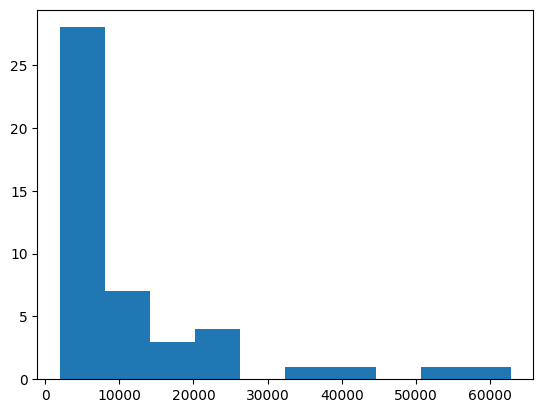

count    41.000000
mean     24.121951
std      16.315936
min       6.000000
25%      13.000000
50%      19.000000
75%      31.000000
max      68.000000
Name: age, dtype: float64


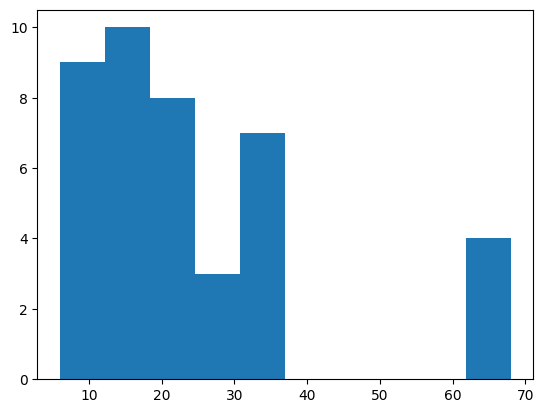

In [ ]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [ ]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                          \
           count          mean           std      min       25%      50%   
brand                                                                      
audi         1.0  37000.000000           NaN  37000.0  37000.00  37000.0   
bmw          3.0  19966.666667  20813.537261   7900.0   7950.00   8000.0   
chevrolet    4.0  10875.000000   9393.038202   3000.0   3375.00   9000.0   
chevy        3.0  11616.666667  11515.677719   4450.0   4975.00   5500.0   
dodge        1.0  18900.000000           NaN  18900.0  18900.00  18900.0   
ford         3.0  21333.333333  29173.332572   3500.0   4500.00   5500.0   
gmc          2.0  16475.000000  13470.384182   6950.0  11712.50  16475.0   
honda        5.0   5629.800000   2372.328013   2300.0   4700.00   5900.0   
jeep         2.0   9500.000000      0.000000   9500.0   9500.00   9500.0   
lexus        2.0  11175.000000    318.198052  10950.0  11062.50  11175.0   
missing     14.0  10089.214286  16148.241324   2000.0   3312.50   4650.0   
mitsubishi   1.0   7300.000000           NaN   7300.0   7300.00   7300.0   
subaru       1.0   3900.000000           NaN   3900.0   3900.00   3900.0   
toyota       4.0   9549.750000   7072.121340   2199.0   4299.75   9500.0   

                               
                 75%      max  
brand                          
audi        37000.00  37000.0  
bmw         26000.00  44000.0  
chevrolet   16500.00  22500.0  
chevy       15200.00  24900.0  
dodge       18900.00  18900.0  
ford        30250.00  55000.0  
gmc         21237.50  26000.0  
honda        6500.00   8749.0  
jeep         9500.00   9500.0  
lexus       11287.50  11400.0  
missing      6749.75  62800.0  
mitsubishi   7300.00   7300.0  
subaru       3900.00   3900.0  
toyota      14750.00  17000.0

In [ ]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                    
           count       mean        std   min   25%   50%   75%   max
brand                                                               
audi         1.0   6.000000        NaN   6.0   6.0   6.0   6.0   6.0
bmw          2.0  15.000000   1.414214  14.0  14.5  15.0  15.5  16.0
chevrolet    4.0  44.000000  16.000000  36.0  36.0  36.0  44.0  68.0
chevy        3.0  20.000000  12.124356   7.0  14.5  22.0  26.5  31.0
dodge        1.0  27.000000        NaN  27.0  27.0  27.0  27.0  27.0
ford         3.0  22.666667   1.154701  22.0  22.0  22.0  23.0  24.0
gmc          1.0  27.000000        NaN  27.0  27.0  27.0  27.0  27.0
honda        5.0  18.000000   9.000000  10.0  13.0  15.0  19.0  33.0
jeep         2.0  22.000000  14.142136  12.0  17.0  22.0  27.0  32.0
lexus        2.0  17.000000   5.656854  13.0  15.0  17.0  19.0  21.0
missing     11.0  30.636364  23.585049   7.0  12.0  20.0  49.0  68.0
mitsubishi   1.0  17.000000        NaN  17.0  17.0  17.0  17.0  17.0
subaru       1.0  11.000000        NaN  11.0  11.0  11.0  11.0  11.0
toyota       4.0  15.500000   3.109126  12.0  13.5  15.5  17.5  19.0

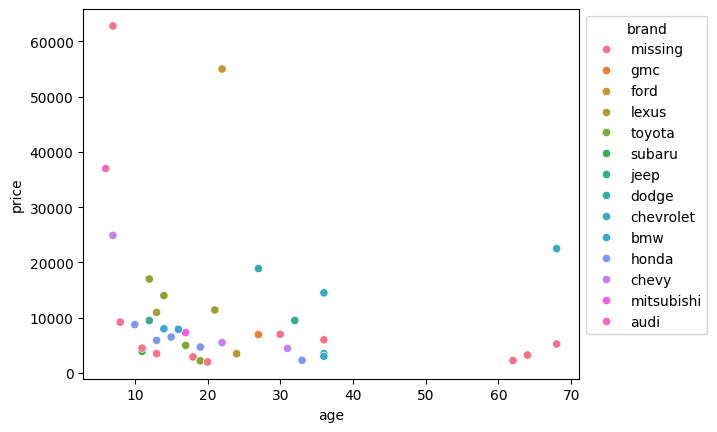

In [ ]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   0.783367 -0.196806
log_age    -0.196806  0.382606
           log_price   log_age
log_price   1.000000 -0.376511
log_age    -0.376511  1.000000


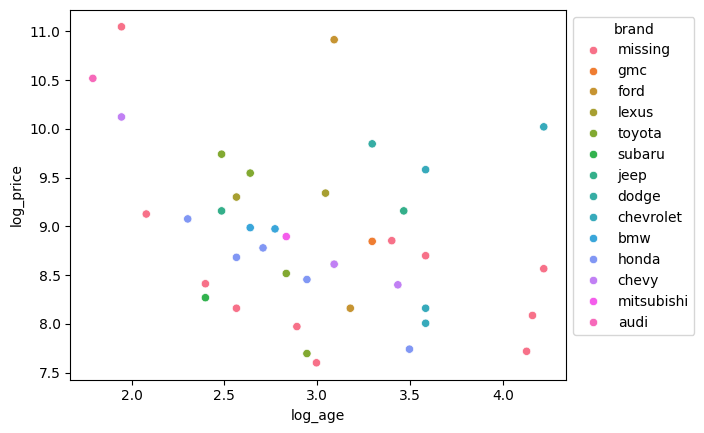

In [ ]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.

1. I'm choosing to look at laptops and other digital devices on Craigslist. I'm going to gather "price", "brand", and "type" (of product) if available in the title of the product. I want to explore the relationship between brand and price and type and price.
2. Shown in code
3. Because there were so many missing values for the brand, it is difficult to look at the effect of brand on price, but based on the given data, it seems like there was the most variation for Dell products. The Canon and Panasonic products seem to have the lowest prices, and the product with the highest price whose brand we know is from Aresgame. For the type of products, computers have the highest range of prices. It also has the max price in the dataset, $3000. Printers and trackpads are either the least common type of product or have the least variation. There are fewer missing values for this variable, so it is easier to observe trends.

(30, 5)
count      30.000000
mean      596.300000
std       652.739857
min         0.000000
25%        98.000000
50%       385.000000
75%       875.000000
max      3000.000000
Name: price, dtype: float64


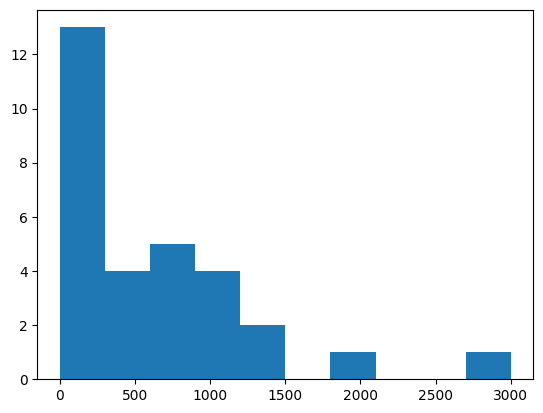

count          30
unique         10
top       missing
freq           15
Name: brand, dtype: object


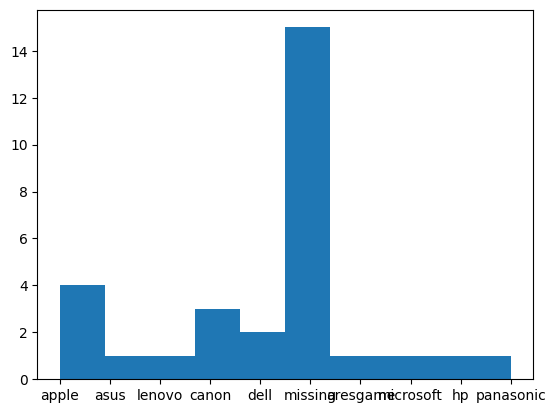

count        30
unique        9
top       tower
freq          8
Name: type, dtype: object


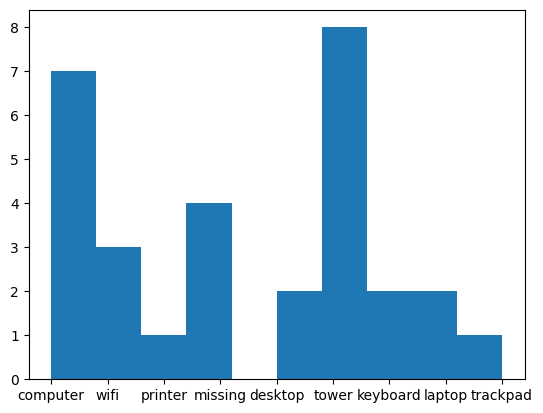

          price                                                               
          count        mean         std    min     25%    50%      75%     max
brand                                                                         
apple       4.0  230.000000  132.664992   50.0  200.00  250.0   280.00   370.0
aresgame    1.0  800.000000         NaN  800.0  800.00  800.0   800.00   800.0
asus        1.0  400.000000         NaN  400.0  400.00  400.0   400.00   400.0
canon       3.0   23.333333   40.414519    0.0    0.00    0.0    35.00    70.0
dell        2.0  237.500000  159.099026  125.0  181.25  237.5   293.75   350.0
hp          1.0  140.000000         NaN  140.0  140.00  140.0   140.00   140.0
lenovo      1.0   50.000000         NaN   50.0   50.00   50.0    50.00    50.0
microsoft   1.0  400.000000         NaN  400.0  400.00  400.0   400.00   400.0
missing    15.0  970.600000  731.783809   45.0  700.00  900.0  1100.00  3000.0
panasonic   1.0   75.000000         NaN   75.0   75.

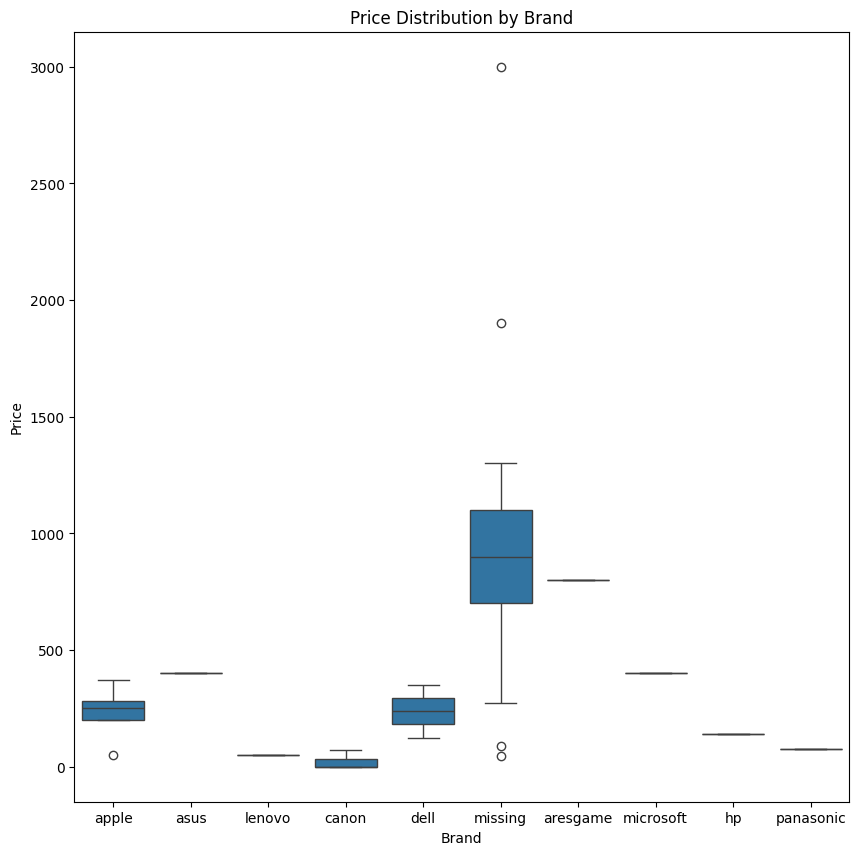

         price                                                                
         count        mean          std    min     25%    50%      75%     max
type                                                                          
computer   7.0  946.428571  1107.025723   50.0  250.00  275.0  1400.00  3000.0
desktop    2.0  247.500000   173.241161  125.0  186.25  247.5   308.75   370.0
keyboard   2.0  700.000000   424.264069  400.0  550.00  700.0   850.00  1000.0
laptop     2.0  445.000000   431.335137  140.0  292.50  445.0   597.50   750.0
missing    4.0  106.250000   166.301684    0.0    0.00   37.5   143.75   350.0
printer    1.0   70.000000          NaN   70.0   70.00   70.0    70.00    70.0
tower      8.0  925.000000   225.198325  700.0  775.00  850.0  1050.00  1300.0
trackpad   1.0   50.000000          NaN   50.0   50.00   50.0    50.00    50.0
wifi       3.0  178.000000   193.512274   45.0   67.00   89.0   244.50   400.0


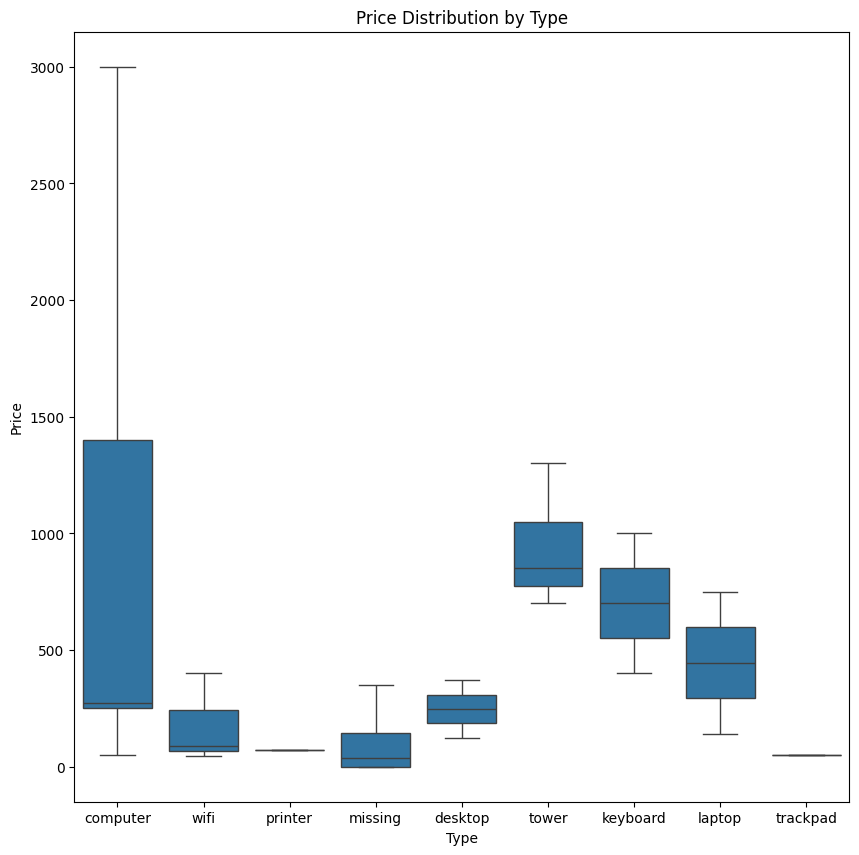

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup as soup
import requests
import re

#web-scraping
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/sya?purveyor=owner#search=2~gallery~0'
raw = requests.get(url,headers=header)
beautifulSoupObj = soup(raw.content,'html.parser')
listings = beautifulSoupObj.find_all(class_="cl-static-search-result")

brands = ['apple', 'canon','asus','dell','microsoft','hp','aresgame','panasonic','lenovo'] #all possible brands, found after browsing the craigslist page
typeProd = ['printer','laptop','computer','desktop','wifi','keyboard','trackpad','tower']
data = []
#consolidating all features into a dictionary of data
for k in range(len(listings)):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    words = title.split(" ")
    brand = 'missing'
    prod = 'missing'
    for word in words:
      if word in brands:
        brand = word
      if word in typeProd:
        prod = word
    data.append({'title':title,'price':price,'link':link,'brand':brand,'type':prod})

#putting data into dataframa and wrangling
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
print(df.shape)
df.to_csv('craigslist_cvilledevices.csv')
df.head()

#to start off my analysis, i want to see individual distributions for each variable
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['brand'].describe())
df['brand'].hist(grid=False)
plt.show()
print(df['type'].describe())
df['type'].hist(grid=False)
plt.show()

#first, i want to compare brand and price
print(df.loc[:,['price','brand']].groupby('brand').describe())
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=df, x='brand', y='price')
plt.title('Price Distribution by Brand')
plt.xlabel('Brand')
plt.ylabel('Price')
plt.show()

#next, i want to compare type and price
print(df.loc[:,['price','type']].groupby('type').describe())
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=df, x='type', y='price')
plt.title('Price Distribution by Type')
plt.xlabel('Type')
plt.ylabel('Price')
plt.show()

